# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Знакомство и проверка данных

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from numpy.random import RandomState

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    raise Exception('Something is wrong. Check the files')

In [3]:
# Посмотрим на полученные данные
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Мы имеем три датасета из трех регионов. Каждый фрейм содержит следующие данные:
- **id** — уникальный идентификатор скважины;
- **f0**, **f1**, **f2** — три признака точек;
- **product** — объём запасов в скважине (тыс. баррелей).

Посмотрим на информацию по датафреймам.

In [6]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
# заодно проверим возможное наличие явных дубликатов
datasets = [data_0, data_1, data_2]
for ds in datasets:
    print(ds.duplicated().sum())

0
0
0


Каждый набор данных имеет по 100000 строк без дубликатов и пропусков.

In [10]:
data_0[['f0', 'f1', 'f2']].corr()

,f0,f1,f2
f0,1.000000,-0.440723,-0.003153
f1,-0.440723,1.000000,0.001724
f2,-0.003153,0.001724,1.000000


В первом датафрейме выделяется только отрицательная корреляция между f0 и f1, но остается в пределах умеренной.

In [11]:
data_1[['f0', 'f1', 'f2']].corr()

,f0,f1,f2
f0,1.000000,0.182287,-0.001777
f1,0.182287,1.000000,-0.002595
f2,-0.001777,-0.002595,1.000000


Во втором датафрейме корреляция между теми же показателями слабая.

In [12]:
data_2[['f0', 'f1', 'f2']].corr()

,f0,f1,f2
f0,1.000000,0.000528,-0.000448
f1,0.000528,1.000000,0.000779
f2,-0.000448,0.000779,1.000000


В третьем датафрейме корреляция практически отсутствует.

### Подготовка данных

В рамках исследования мы будем строить модели, предсказывающие объем запасов в скважинах, то есть находить количественное значение. Для этого будем использовать линейную регрессию. Все нужные нам признаки уже численные, и есть только один категориальный, а именно *id*. Так как это лишь уникальный идентификатор скважины, то его мы не будем использовать для обучения модели, он не несет полезной информации именно о скважине. Кодировать категориальные признаки необходимости нет, поэтому взглянем, требуется ли масштабирование числовых признаков.

In [13]:
# сохраним список признаков
features_list = ['f0', 'f1', 'f2']

# проверим размах значений в каждом датафрейме
for i in datasets:
    for j in features_list:
        print(f'Признак {j} имеет минимум {i[j].min()} и максимум {i[j].max()}')

Признак f0 имеет минимум -1.408605306026996 и максимум 2.362330810854224
Признак f1 имеет минимум -0.8482184970082173 и максимум 1.343769333804496
Признак f2 имеет минимум -12.08832811806336 и максимум 16.003790007695365
Признак f0 имеет минимум -31.609576019167687 и максимум 29.42175461390372
Признак f1 имеет минимум -26.358598008345872 и максимум 18.73406263373076
Признак f2 имеет минимум -0.0181440867134202 и максимум 5.019720555223062
Признак f0 имеет минимум -8.760003624213763 и максимум 7.23826247979405
Признак f1 имеет минимум -7.084019760867246 и максимум 7.844801270084258
Признак f2 имеет минимум -11.97033454147699 и максимум 16.73940205869952


Видим, что значения не укладываются в один масштаб, поэтому будет лучше провести трансформацию при помощи StandardScaler, но сначала разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [14]:
# обозначим единый рандом для всей работы
RANDOM_STATE = 999

In [15]:
# напишем функцию для разделения признаков
def split_features(df):
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    return features, target

In [16]:
# разделим признаки
features_0, target_0 = split_features(data_0)
features_1, target_1 = split_features(data_1)
features_2, target_2 = split_features(data_2)

In [17]:
# разбиваем на обучающую и валидационную выборки
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=RANDOM_STATE
)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=RANDOM_STATE
)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=RANDOM_STATE
)

In [18]:
# проверяем результат на одном разбиении
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [19]:
# создаем экземпляр скейлера
scaler = StandardScaler()

In [20]:
# опишем функцию преобразования признаков для всех регионов
def scale(features, valid):
    scaler.fit(features)
    features = scaler.transform(features)
    valid = scaler.transform(valid)
    return pd.DataFrame(features), pd.DataFrame(valid)

In [21]:
# преобразуем данные для всех выборок
features_train_0, features_valid_0 = scale(features_train_0, features_valid_0)
features_train_1, features_valid_1 = scale(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scale(features_train_2, features_valid_2)

In [22]:
# проверим один пример
features_train_0.head()

,0,1,2
0,0.223888,-1.115708,1.946846
1,-0.513837,0.209848,1.573385
2,-0.403147,0.310253,0.109633
3,1.038636,-1.411883,0.251348
4,-1.777952,0.029269,-0.633705


Здесь мы заканчиваем с предобработкой данных и переходим к обучению моделей.

## Обучение и проверка модели

На этом этапе нам нужно обучить модель для каждого региона и получить предсказанные ответы. Дополнительно высчитываем RMSE, средний запас предсказанного сырья и метрику R2.

In [23]:
# создаем экземляр модели
model = LinearRegression()

In [24]:
# запишем функцию для обучения для каждого региона
def train_model(features_train, target_train, features_valid, target_valid): 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid, squared=False)
    r2 = r2_score(target_valid, predicted_valid)
    mean_predict_valid = predicted_valid.mean()
    return predicted_valid, mean_predict_valid, rmse, r2

In [25]:
# обучим три модели
predicted_valid_0, mean_predict_valid_0, rmse_0, r2_0 = train_model(
    features_train_0, target_train_0, features_valid_0, target_valid_0)

predicted_valid_1, mean_predict_valid_1, rmse_1, r2_1 = train_model(
    features_train_1, target_train_1, features_valid_1, target_valid_1)

predicted_valid_2, mean_predict_valid_2, rmse_2, r2_2 = train_model(
    features_train_2, target_train_2, features_valid_2, target_valid_2)

In [26]:
# выведем промежуточные результаты
print(f'Среднее значение предсказанных запасов в 1 регионе: {mean_predict_valid_0}, RMSE: {rmse_0}, R2: {r2_0}')
print(f'Среднее значение предсказанных запасов в 2 регионе: {mean_predict_valid_1}, RMSE: {rmse_1}, R2: {r2_1}')
print(f'Среднее значение предсказанных запасов в 3 регионе: {mean_predict_valid_2}, RMSE: {rmse_2}, R2: {r2_2}')

Среднее значение предсказанных запасов в 1 регионе: 92.53481054203547, RMSE: 37.73025860379069, R2: 0.27937135066413776
Среднее значение предсказанных запасов в 2 регионе: 68.86449441788326, RMSE: 0.8865534226245153, R2: 0.9996275390211119
Среднее значение предсказанных запасов в 3 регионе: 95.12772725874514, RMSE: 40.16077130943588, R2: 0.19650958156287912


In [27]:
print(f'Истинные средние валидационной выборки: \n 1: {target_valid_0.mean()}, \n 2: {target_valid_1.mean()}, \n \
3: {target_valid_2.mean()}')

Истинные средние валидационной выборки: 
 1: 92.22389862083566, 
 2: 68.86939132980969, 
 3: 94.74299913039822


Мы обучили три модели и в качестве оценки их качества можно сказать, что нет моделей с отрицательной R2-метрикой, значит, все будут выполнять задачу, однако, для 1 и 3 региона значение ближе к 0, чем к 1, поэтому есть вероятность, что они будут хуже справляться с незнакомыми данными. А вот модель для 2 региона показывает результат, близкий к идеальному.

В сравнении предсказанных средних значений и истинных мы получили примерно одинаковые результаты.

## Подготовка к расчёту прибыли

Сейчас нам нужно рассчитать объем сырья, который нужен для безубыточной разработки. Общий бюджет на разработку скважин составляет **10 млрд рублей**, а доход с каждой единицы сырья равен **450 тыс. рублей**. В каждом регионе исследуются **500** точек, а по итогу выбираются **200**.

In [28]:
total_budget = 10000000000
unit_revenue = 450000
unit_count = 200
min_dev_cost = total_budget / unit_count
print(f'На каждую скважину может потребоваться не менее {min_dev_cost} руб.')

На каждую скважину может потребоваться не менее 50000000.0 руб.


Если потратить весь бюджет, то каждая скважина потребует **50 млн. руб.**. Чтобы не остаться в убытке, каждая скважина должна иметь в наличии объем сырья как минимум окупающий разработку. 

In [29]:
# посчитаем, сколько нужно сырья, чтобы выйти в ноль, и округлим в большую сторону
raw_material_volume = min_dev_cost / unit_revenue
print(f'{raw_material_volume:.{3}f}')

111.111


In [30]:
# истинные средние значения единиц сырья по всем данным
print(data_0['product'].mean())
print(data_1['product'].mean())
print(data_2['product'].mean())

92.50000000000001
68.82500000000002
95.00000000000004


То есть выбранные скважины должны иметь как минимум **111,111 тыс.** баррелей сырья, чтобы не допустить убытков. Или по-другому **22222,2 тыс.** баррелей с региона. Средние значения сырья в каждом регионе не превышают 112 единиц продукта, поэтому на этом этапе безубыточность не гарантируется. Теперь перейдем к самому расчету прибыли и рисков.

## Расчёт прибыли и рисков 

In [31]:
# напишем функцию подсчета прибыли по самым лучшим предсказанным значениям
def profit_calculation(pred_values, target_values):
    '''Функция принимает предсказанные и истинные значения,
    после чего берет 200 лучших предсказанных и находит
    сумму истинных значений выбранных скважин
    и вычисляет валовую прибыль'''
    y_true = target_values.reset_index(drop=True)
    pred_sum = pd.Series(pred_values).sort_values(ascending=False)[:200].index
    all_sum = y_true.iloc[pred_sum].sum()
    return all_sum * unit_revenue - total_budget

In [32]:
profit_0 = profit_calculation(predicted_valid_0, target_valid_0)
profit_1 = profit_calculation(predicted_valid_1, target_valid_1)
profit_2 = profit_calculation(predicted_valid_2, target_valid_2)
print(f'Прогнозируемая валовая прибыль для 1 региона: {profit_0 / 1000000000:.{3}f} млрд.')
print(f'Прогнозируемая валовая прибыль для 2 региона: {profit_1 / 1000000000:.{3}f} млрд.')
print(f'Прогнозируемая валовая прибыль для 3 региона: {profit_2 / 1000000000:.{3}f} млрд.')

Прогнозируемая валовая прибыль для 1 региона: 3.175 млрд.
Прогнозируемая валовая прибыль для 2 региона: 2.415 млрд.
Прогнозируемая валовая прибыль для 3 региона: 2.247 млрд.


На этом этапе мы видим, что по прогнозу больше всего прибыли может принести первый регион, но R2-метрика модели предсказания для этого региона была не самой высокой. Меньше всего прибыли прогнозируется в 3 регионе. Ситуация неопределенная, поэтому нам стоит оценить риски и выбрать тот регион или регионы, где вероятность убытков будет меньше 2,5%. Для этого используем bootstrap.

In [33]:
# подготовим экземпляр RandomState, чтобы не получать одинаковые выборки
state = RandomState(RANDOM_STATE)

In [34]:
# сбросим индексы для target значений
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

In [35]:
# опишем функцию для получения прибыли в случайных выборках
def get_better_wells(target, predict, count):
    predict_sorted = predict.sort_values(ascending=False)
    selected_well = target[predict_sorted.index][:count]
    return selected_well.sum() * unit_revenue - total_budget

In [37]:
# опишем функцию для бутстрепа моделей
def bootstrap(target, predict, count):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index] 
        target_subsample = target_subsample.reset_index(drop=True)
        predict_subsample = pd.Series(predict_subsample).reset_index(drop=True)
        values.append(get_better_wells(target_subsample, predict_subsample, count))
    return pd.Series(values)

In [39]:
values_0 = bootstrap(target_valid_0, predicted_valid_0, unit_count)
values_1 = bootstrap(target_valid_1, predicted_valid_1, unit_count)
values_2 = bootstrap(target_valid_2, predicted_valid_2, unit_count)

In [40]:
def evaulate_results(values):
    '''Функция вычисляет среднюю прибыль всего региона по данным бутстрепа,
    а также 95% доверительный интервал и процент убытков,
    где прибыль оказывается ниже затраченного бюджета'''
    mean_revenue = values.mean()
    
    quan_025 = values.quantile(0.025)
    quan_975 = values.quantile(0.975)
    
    count_loss = 0
    for i in values:
        if i < 0:
            count_loss += 1
    loss_rate = count_loss / len(values)
    
    return mean_revenue, quan_025, quan_975, loss_rate * 100

In [41]:
for i, name in enumerate([values_0, values_1, values_2]):
    mean, quan_025, quan_975, rate = evaulate_results(name)
    print(f'Средняя прибыль в регионе {i + 1}: {mean}')
    print(f'Доверительный 95% интервал: ({quan_025}, {quan_975})')
    print(f'Доля убытков: {rate}%')
    print('')

Средняя прибыль в регионе 1: 415255763.88382435
Доверительный 95% интервал: (-83112805.57303919, 913061073.7819686)
Доля убытков: 5.8999999999999995%

Средняя прибыль в регионе 2: 464016698.60296035
Доверительный 95% интервал: (68063072.54372741, 874460584.3922478)
Доля убытков: 0.7000000000000001%

Средняя прибыль в регионе 3: 345530834.51330787
Доверительный 95% интервал: (-195560548.72156453, 882333753.9569058)
Доля убытков: 10.6%



В итоге мы получаем, что только второй регион имеет меньше 2,5% убытков, а также самую большую предполагаемую среднюю прибыль. Дополнительно покажем это на боксплотах ниже.

<AxesSubplot:>

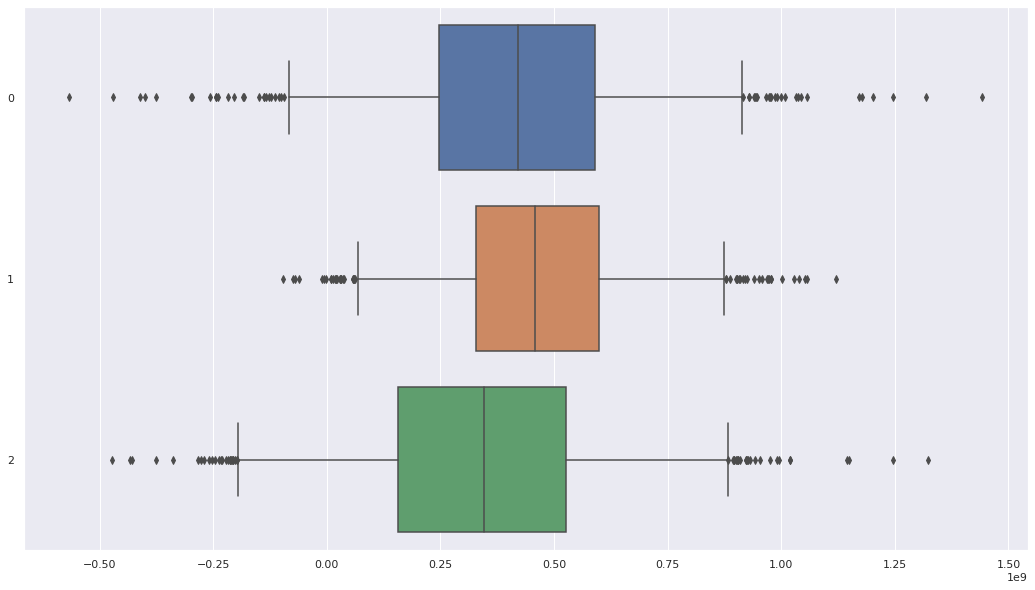

In [42]:
concat_data = pd.concat([values_0, values_1, values_2], axis=1)
sns.set(rc={"figure.figsize":(18,10)}) 
sns.boxplot(data=concat_data, orient='h', whis=[2.5, 97.5])

## Вывод

В ходе данного исследования мы изучили данные по трем регионам и построили для каждой модель линейной регрессии. После этого посчитали вероятную прибыль и другие метрики, а после применили бутстреп, чтобы минимизировать влияние случайности. Для этого для каждого региона взяли по 1000 случайных выборок по 500 месторождений, из которых взяли 200 самых перспективных. 

После этого рассчитали уже по этим данным среднюю прибыль и доверительный интервал. Нам нужно было, чтобы доля убытков была меньше 2,5%, что удалось обнаружить только для второго региона. Также у второго региона больше средняя прибыль по выборкам, а также метрика R2 для модели линейной регрессии почти близка к идеальной в отличии от моделей других регионов. Это значит, что эта модель с большей вероятностью допустит меньшее расхождение прогнозов от истинных значений. Рекомендую в первую очередь рассматривать второй регион для разработки скважин.